In [63]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import GUIDE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from random import shuffle
import scipy.stats as ss
import matplotlib.animation as animation

In [14]:
#print("--- %s seconds ---" % (time.time() - start_time))


np.set_printoptions(precision=None, floatmode = 'maxprec_equal', suppress = None)
rng = np.random.default_rng()

M=10
L=3
T=6

print("M = ",M, ", K = ",K, ", T = ",T)

# effect sizes or network weights from variants to latents, latents to phenos
# drawn independently from spike-and-slab (more precisely, point-normal) dist

# simulate new data
s_1 = 1
s_2 = 2

a = rng.choice([s_1,s_2],p=[0.7,0.3],size=(M,K))
b = rng.choice([s_1,s_2],p=[0.8,0.2],size=(K,T))
X = rng.normal(0, a, size=(M, K)) 
#Y = rng.exponential(b, size=(K, T)) 
Y = rng.normal(0, b, size=(K, T))  

s = rng.choice([1, 1.1],p=[.5,.5])
# b_X = rng.binomial(1, 0.5, size=(M, K))
# b_Y = rng.binomial(1, 0.5, size=(K, T))    
#X = rng.normal(0, 1, size=(M, K)) * b_X + rng.normal(0, 1.5, size=(M, K)) * (1-b_X) #* rng.exponential(10.0)
#Y = rng.normal(0, 1, size=(K, T))  * b_Y + rng.normal(0, 1.5, size=(K, T))  * (1- b_Y ) #* rng.binomial(1, 0.5, size=(K, T))

G = np.matmul(X , Y)

# mean center G rows and columns
G = G - np.mean(G, axis = 0)
G = G - np.mean(G, axis = 1)[:,np.newaxis]


M =  10 , K =  3 , T =  6


In [15]:
# TSVD

U, Vt, S = GUIDE.tsvd(G, L=K)

# GUIDE

W_XL,W_LT,Sc,A = GUIDE.guide(G, L=K,standardize=False)

In [16]:
# check reconstruction on left; should be close to a signed permutation matrix
corr=np.corrcoef(np.concatenate((X, W_XL), axis = 1), rowvar=False)[K:, :K]
#print(corr)

# create the signed permutation matrix
def corr2flip(C):
    return np.where(abs(C) < 0.7, 0, np.sign(C))

# check it really is one, and double check it is orthogonal
flip = corr2flip(corr)
#print(flip)
print(flip @ flip.T)

# apply to reconstructed data to match order and signs of latent dimensions to original simulated data
# (note that this step only applies to simulations; order and signs are in general arbitrary)
W_XL = np.matmul(W_XL , flip)
W_LT = np.matmul(flip.T , W_LT)


# complete recipe for reconstructed data matrix
#print("check =", np.allclose(X_rec @ flip.T @ mix.T @ np.diag(S) @ mix @ flip @ Y_rec, G))


[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [17]:
color=list(mcolors.CSS4_COLORS)
shuffle(color)

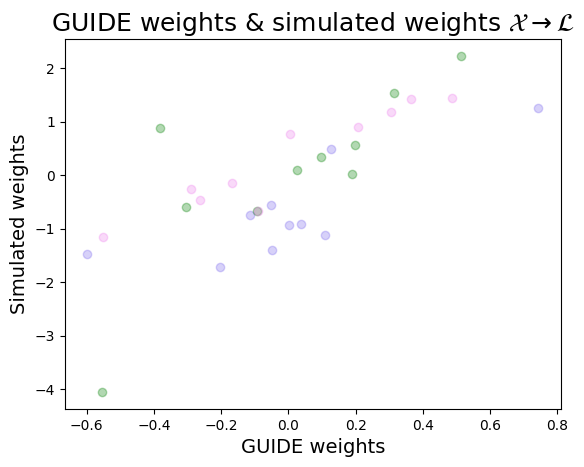

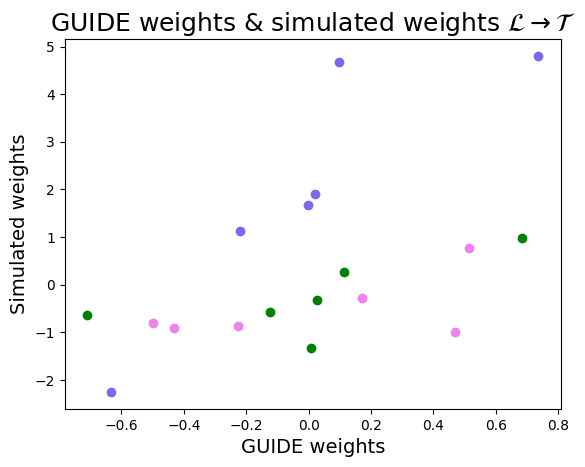

In [18]:
# GUIDE
y_01_plotset=[]              # prep for scatterplot 
x_01_plotset=[]

for i in range(K):
    y_01_plotset.insert(i,X.T[i])
    x_01_plotset.insert(i,W_XL.T[i])
y_01_plotset=np.array(y_01_plotset)
x_01_plotset=np.array(x_01_plotset)

y_12_plotset=[]
x_12_plotset=[]

for i in range(K):
    y_12_plotset.insert(i,(Y[i]))
    x_12_plotset.insert(i,W_LT[i])
y_12_plotset=np.array(y_12_plotset)
x_12_plotset=np.array(x_12_plotset)

fig,ax1=plt.subplots()
for i in range(K):
    plt.scatter(x_01_plotset[i],y_01_plotset[i],c=color[i],alpha=0.3)
#ax1.set_yscale('linear')
plt.title("GUIDE weights & simulated weights $\\mathcal{X} \\rightarrow \\mathcal{L}$",size=18)
plt.xlabel("GUIDE weights",size=14)
plt.ylabel("Simulated weights",size=14)
ax1.legend
#plt.savefig('sim-XL_GUIDE_M1e6-L50-T1e3.png',dpi=400)
plt.show()

#plt.scatter(g12_est,gammas_out_Y1Y2)
fig,ax1=plt.subplots()
for i in range(K):
    plt.scatter(x_12_plotset[i],y_12_plotset[i],c=color[i])
plt.title("GUIDE weights & simulated weights $\\mathcal{L} \\rightarrow \\mathcal{T}$",size=18)
plt.xlabel("GUIDE weights",size=14)
plt.ylabel("Simulated weights",size=14)
ax1.legend
#plt.savefig('sim-LT_GUIDE_M1e6-L50-T1e3.png',dpi=400)
plt.show()


In [19]:
var_comp_XL = GUIDE.var_comp(G, W_LT)
var_comp_LT = GUIDE.var_comp(G, W_XL)


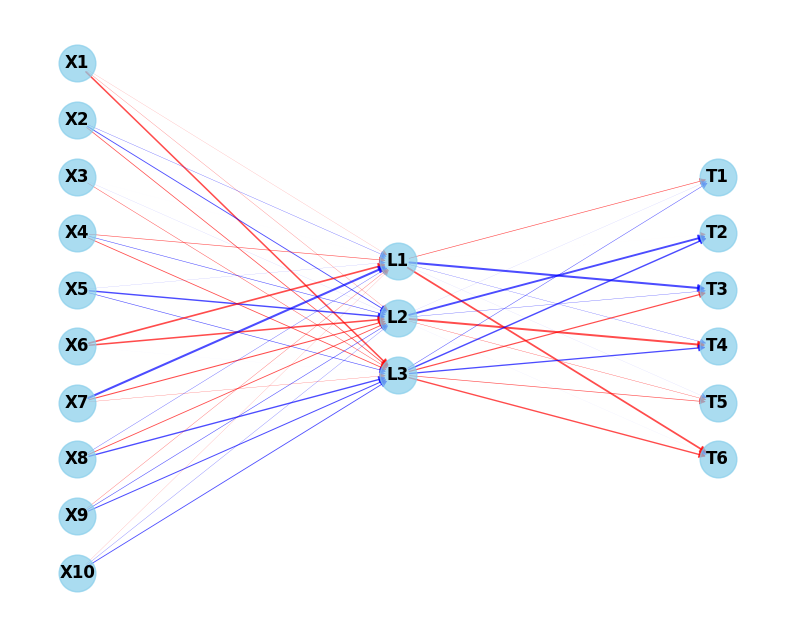

In [60]:
def draw_three_layer_network_with_weights(layer1_nodes, layer2_nodes, layer3_nodes, 
                                          edge_weights_l1_l2, edge_weights_l2_l3, 
                                          layer_spacing=2):
    """
    Draws a 3-layer network with adjustable edge widths and colors based on edge weights,
    with nodes numbered from top to bottom in each layer.
    
    Parameters:
    - layer1_nodes, layer2_nodes, layer3_nodes: Lists of nodes for each layer.
    - edge_weights_l1_l2: 2D array of weights for edges from layer 1 to layer 2.
    - edge_weights_l2_l3: 2D array of weights for edges from layer 2 to layer 3.
    - layer_spacing: Vertical spacing between nodes within each layer.
    """
    # Create a new directed graph
    G = nx.DiGraph()

    # Add nodes for each layer
    G.add_nodes_from(layer1_nodes)
    G.add_nodes_from(layer2_nodes)
    G.add_nodes_from(layer3_nodes)

    # Set positions for the nodes
    pos = {}

    # Calculate vertical positions (y-coordinates) for each layer
    # Center the nodes vertically by distributing them evenly around y = 0
    def get_layer_positions(nodes, layer_x):
        """
        Function to return a dictionary with node positions for a specific layer
        with nodes numbered from top to bottom.
        """
        n = len(nodes)
        positions = {}
        # Calculate vertical spacing
        for i, node in enumerate(nodes):
            # The formula below places the first node at the top and spaces nodes downward
            y_position = ((n - 1) / 2 - i) * layer_spacing
            positions[node] = (layer_x, y_position)
        return positions

    # Layer 1 (x=0, numbered top to bottom)
    pos.update(get_layer_positions(layer1_nodes, 0))
    
    # Layer 2 (x=1, numbered top to bottom)
    pos.update(get_layer_positions(layer2_nodes, 1))

    # Layer 3 (x=2, numbered top to bottom)
    pos.update(get_layer_positions(layer3_nodes, 2))

    # Initialize edge list and properties
    edges = []
    edge_widths = []
    edge_colors = []

    # Define edges and calculate edge properties (width and color)
    # From layer 1 to layer 2
    for i, node1 in enumerate(layer1_nodes):
        for j, node2 in enumerate(layer2_nodes):
            weight = edge_weights_l1_l2[i][j]
            edges.append((node1, node2))
            edge_widths.append(abs(weight))  # Line width based on absolute weight
            edge_colors.append('blue' if weight > 0 else 'red')  # Color based on weight sign

    # From layer 2 to layer 3
    for i, node2 in enumerate(layer2_nodes):
        for j, node3 in enumerate(layer3_nodes):
            weight = edge_weights_l2_l3[i][j]
            edges.append((node2, node3))
            edge_widths.append(abs(weight))  # Line width based on absolute weight
            edge_colors.append('blue' if weight > 0 else 'red')  # Color based on weight sign

    # Draw the network
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black")
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.7, edge_color=edge_colors)

    # Display the plot
    plt.axis('off')  # Hide the axes
    #plt.savefig('GUIDE_network.png',dpi=400)
    #plt.show()
    

# Example usage with 10 nodes in layer 1, 3 nodes in layer 2, and 6 nodes in layer 3
layer1_nodes = [f'X{i+1}' for i in range(M)]  # Nodes in Layer 1: A1, A2, ..., A10
layer2_nodes = [f'L{i+1}' for i in range(L)]   # Nodes in Layer 2: B1, B2, B3
layer3_nodes = [f'T{i+1}' for i in range(T)]   # Nodes in Layer 3: C1, C2, ..., C6

# Define edge weight matrices
# Weight matrix for edges from layer 1 to layer 2 (10x3 matrix)
edge_weights_l1_l2 = 2*W_XL #var_comp_XL
#np.random.uniform(-5, 5, (10, 3))

# Weight matrix for edges from layer 2 to layer 3 (3x6 matrix)
edge_weights_l2_l3 = 2*W_LT #var_comp_LT.T
#np.random.uniform(-5, 5, (3, 6))

# Draw the network with the generated weights
draw_three_layer_network_with_weights(layer1_nodes, layer2_nodes, layer3_nodes,
                                      edge_weights_l1_l2, edge_weights_l2_l3)

# Save the last figure manually
#plt.pause(1)
plt.savefig('GUIDE_network.png',dpi=400,bbox_inches='tight')
plt.show()

**Ground truth network:**

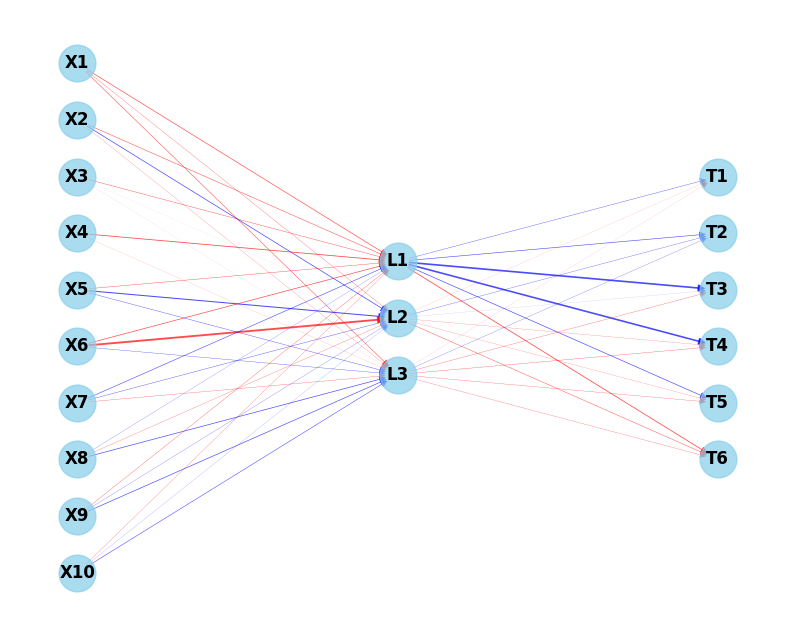

In [72]:

# Define edge weight matrices
# Weight matrix for edges from layer 1 to layer 2 (10x3 matrix)
edge_weights_l1_l2 = X/3 #var_comp_XL
#np.random.uniform(-5, 5, (10, 3))

# Weight matrix for edges from layer 2 to layer 3 (3x6 matrix)
edge_weights_l2_l3 = Y/4 #var_comp_LT.T
#np.random.uniform(-5, 5, (3, 6))

# Draw the network with the generated weights
draw_three_layer_network_with_weights(layer1_nodes, layer2_nodes, layer3_nodes,
                                      edge_weights_l1_l2, edge_weights_l2_l3)

# Save the last figure manually
#plt.pause(1)
#plt.savefig('GUIDE_network.png',dpi=400,bbox_inches='tight')
plt.show()

In [71]:
# Rotated weights
( W_XL@ss.ortho_group.rvs(L) )

array([[ 0.40921464,  0.38086412, -0.05283052],
       [ 0.32571861, -0.09361314, -0.25548017],
       [ 0.14371462,  0.07665060, -0.05276515],
       [ 0.15329559,  0.19175402, -0.31828331],
       [-0.06732082, -0.40722112, -0.36897439],
       [-0.42126176,  0.68087107,  0.15255137],
       [ 0.42530533, -0.23351094,  0.68612796],
       [-0.37574013, -0.18582806,  0.41363398],
       [-0.33151899, -0.22761085, -0.15569209],
       [-0.26140708, -0.18235570, -0.04828768]])

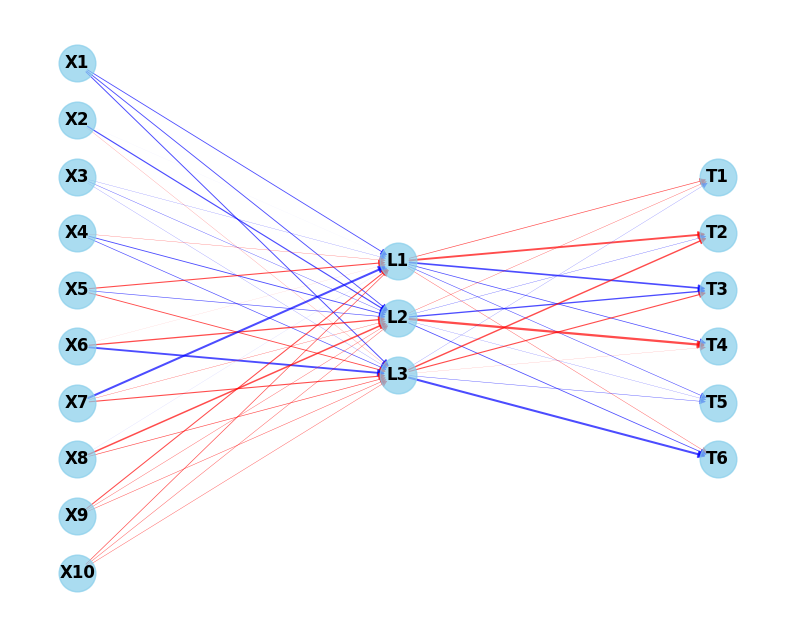

In [62]:

# Define edge weight matrices
# Weight matrix for edges from layer 1 to layer 2 (10x3 matrix)
rotate = ss.ortho_group.rvs(L)
edge_weights_l1_l2 = 2*W_XL@rotate
#np.random.uniform(-5, 5, (10, 3))

# Weight matrix for edges from layer 2 to layer 3 (3x6 matrix)
edge_weights_l2_l3 = 2*rotate.T@W_LT 


# Draw the network with the generated weights
draw_three_layer_network_with_weights(layer1_nodes, layer2_nodes, layer3_nodes,
                                      edge_weights_l1_l2, edge_weights_l2_l3)

# Save the last figure manually
#plt.savefig('GUIDE_network_rotated.png',dpi=400,bbox_inches='tight')
plt.show()

In [109]:
def animate_networks(layer1_nodes, layer2_nodes, layer3_nodes, 
                     edge_weight_matrices, interval=1500, save_path="network_animation.gif", 
                     first_title="First Network", threshold=None):
    """
    Creates an animation of multiple 3-layer networks and saves it as a GIF or MP4.

    Parameters:
    - layer1_nodes, layer2_nodes, layer3_nodes: Lists of nodes for each layer.
    - edge_weight_matrices: List of (edge_weights_l1_l2, edge_weights_l2_l3) matrices for different networks.
    - interval: Time in milliseconds each frame is displayed (default: 1500ms = 1.5 seconds).
    - save_path: File path to save the animation (use .gif for GIF, .mp4 for video).
    - first_title: Title for the first network plot.
    - threshold: Minimum absolute edge weight to be displayed. Weights below this are set to 0 (edges removed).
    """

    fig, ax = plt.subplots(figsize=(8, 6))  # Reduce figure size for tighter fit
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)  # Reduce whitespace

    # Function to get node positions
    def get_layer_positions(nodes, layer_x, layer_spacing=2):
        n = len(nodes)
        return {node: (layer_x, ((n - 1) / 2 - i) * layer_spacing) for i, node in enumerate(nodes)}

    # Set positions for nodes
    pos = {}
    pos.update(get_layer_positions(layer1_nodes, 0))
    pos.update(get_layer_positions(layer2_nodes, 1))
    pos.update(get_layer_positions(layer3_nodes, 2))

    def update(frame):
        """Update function for animation."""
        ax.clear()

        # Set custom title for first frame, default numbering for others
        if frame == 0:
            ax.set_title(first_title, fontsize=14, fontweight="bold")
        else:
            ax.set_title(f"Alternative Model {frame + 1}", fontsize=14, fontweight="bold")

        # Get edge weights for this frame
        edge_weights_l1_l2, edge_weights_l2_l3 = edge_weight_matrices[frame]

        G = nx.DiGraph()
        G.add_nodes_from(layer1_nodes)
        G.add_nodes_from(layer2_nodes)
        G.add_nodes_from(layer3_nodes)

        edges, edge_widths, edge_colors = [], [], []

        # Add edges from layer 1 to layer 2
        for i, node1 in enumerate(layer1_nodes):
            for j, node2 in enumerate(layer2_nodes):
                weight = edge_weights_l1_l2[i, j]
                if threshold is None or abs(weight) >= threshold:  # Apply threshold filter
                    edges.append((node1, node2))
                    edge_widths.append(abs(weight))
                    edge_colors.append('blue' if weight > 0 else 'red')

        # Add edges from layer 2 to layer 3
        for i, node2 in enumerate(layer2_nodes):
            for j, node3 in enumerate(layer3_nodes):
                weight = edge_weights_l2_l3[i, j]
                if threshold is None or abs(weight) >= threshold:  # Apply threshold filter
                    edges.append((node2, node3))
                    edge_widths.append(abs(weight))
                    edge_colors.append('blue' if weight > 0 else 'red')

        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.7, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black", ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.7, edge_color=edge_colors, ax=ax)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

        # Reduce margins further
        ax.margins(0.05)

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(edge_weight_matrices), interval=interval)

    # Save animation
    if save_path.endswith(".gif"):
        ani.save(save_path, writer='pillow', fps=1)
    elif save_path.endswith(".mp4"):
        ani.save(save_path, writer='ffmpeg', fps=1)
    
    plt.close(fig)  # Close figure to prevent display in interactive environments

    print(f"Animation saved as {save_path}")

In [112]:
edge_weight_matrices = []
edge_weight_matrices.append((2*W_XL,2*W_LT))
for i in range(5):
    rotate_i = ss.ortho_group.rvs(L)       # rotation (orthogonal) matrix 
    edge_weight_matrices.append( (2*W_XL@rotate_i, 2*rotate_i.T@W_LT) )

In [113]:
# Example with 3 Different Networks
M, L, T = 10, 3, 6  # Number of nodes in each layer

# Generate node labels
layer1_nodes = [f'X{i+1}' for i in range(M)]
layer2_nodes = [f'L{i+1}' for i in range(L)]
layer3_nodes = [f'T{i+1}' for i in range(T)]

# Create different edge weight matrices
# edge_weight_matrices = [
#     (np.random.uniform(-5, 5, (M, L)), np.random.uniform(-5, 5, (L, T))),
#     (np.random.uniform(-5, 5, (M, L)), np.random.uniform(-5, 5, (L, T))),
#     (np.random.uniform(-5, 5, (M, L)), np.random.uniform(-5, 5, (L, T))),
# ]

# Run animation with a custom first title
animate_networks(layer1_nodes, layer2_nodes, layer3_nodes, 
                 edge_weight_matrices, 
                 save_path="network_animation.gif", 
                 first_title="GUIDE model",
                 threshold = None)

Animation saved as network_animation.gif


**Include set of threshold values. Animation sequentially updates plot based on remaining weights after every threshold:**

In [114]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def animate_threshold_effect(layer1_nodes, layer2_nodes, layer3_nodes, 
                             edge_weights_l1_l2, edge_weights_l2_l3, 
                             thresholds=None, interval=1000, save_path="threshold_animation.gif"):
    """
    Animates how a network changes as a threshold is applied to edge weights.

    Parameters:
    - layer1_nodes, layer2_nodes, layer3_nodes: Lists of nodes for each layer.
    - edge_weights_l1_l2: 2D array of weights for edges from layer 1 to layer 2.
    - edge_weights_l2_l3: 2D array of weights for edges from layer 2 to layer 3.
    - thresholds: List of threshold values to test (default = auto-generated).
    - interval: Time in milliseconds each frame is displayed (default: 1000ms).
    - save_path: File path to save the animation (.gif for GIF, .mp4 for video).
    """

    fig, ax = plt.subplots(figsize=(8, 6))  # Reduce figure size for a cleaner layout
    plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)  # Minimize margins

    # Generate threshold values if none are provided
    if thresholds is None:
        max_weight = max(np.abs(edge_weights_l1_l2).max(), np.abs(edge_weights_l2_l3).max())
        thresholds = np.linspace(0, max_weight, num=10)  # 10 steps from 0 to max weight

    # Function to get node positions
    def get_layer_positions(nodes, layer_x, layer_spacing=2):
        n = len(nodes)
        return {node: (layer_x, ((n - 1) / 2 - i) * layer_spacing) for i, node in enumerate(nodes)}

    # Set positions for nodes
    pos = {}
    pos.update(get_layer_positions(layer1_nodes, 0))
    pos.update(get_layer_positions(layer2_nodes, 1))
    pos.update(get_layer_positions(layer3_nodes, 2))

    def update(frame):
        """Update function for animation."""
        ax.clear()
        threshold = thresholds[frame]  # Get current threshold value

        ax.set_title(f"Threshold = {threshold:.2f}", fontsize=14, fontweight="bold")

        G = nx.DiGraph()
        G.add_nodes_from(layer1_nodes)
        G.add_nodes_from(layer2_nodes)
        G.add_nodes_from(layer3_nodes)

        edges, edge_widths, edge_colors = [], [], []

        # Add edges from layer 1 to layer 2
        for i, node1 in enumerate(layer1_nodes):
            for j, node2 in enumerate(layer2_nodes):
                weight = edge_weights_l1_l2[i, j]
                if abs(weight) >= threshold:  # Apply threshold filter
                    edges.append((node1, node2))
                    edge_widths.append(abs(weight))
                    edge_colors.append('blue' if weight > 0 else 'red')

        # Add edges from layer 2 to layer 3
        for i, node2 in enumerate(layer2_nodes):
            for j, node3 in enumerate(layer3_nodes):
                weight = edge_weights_l2_l3[i, j]
                if abs(weight) >= threshold:  # Apply threshold filter
                    edges.append((node2, node3))
                    edge_widths.append(abs(weight))
                    edge_colors.append('blue' if weight > 0 else 'red')

        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.7, ax=ax)
        nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black", ax=ax)
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_widths, alpha=0.7, edge_color=edge_colors, ax=ax)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

        # Reduce margins further
        ax.margins(0.05)

    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(thresholds), interval=interval)

    # Save animation
    if save_path.endswith(".gif"):
        ani.save(save_path, writer='pillow', fps=1)
    elif save_path.endswith(".mp4"):
        ani.save(save_path, writer='ffmpeg', fps=1)
    
    plt.close(fig)  # Close figure to prevent display in interactive environments

    print(f"Animation saved as {save_path}")

In [115]:
# Example network with 10 nodes in layer 1, 3 in layer 2, and 6 in layer 3
M, L, T = 10, 3, 6  

# Generate node labels
layer1_nodes = [f'X{i+1}' for i in range(M)]
layer2_nodes = [f'L{i+1}' for i in range(L)]
layer3_nodes = [f'T{i+1}' for i in range(T)]

# Generate random edge weight matrices
edge_weights_l1_l2 = np.random.uniform(-5, 5, (M, L))
edge_weights_l2_l3 = np.random.uniform(-5, 5, (L, T))

# Define threshold values (optional)
thresholds = [0, 1, 2, 3, 4, 5]  # Manually chosen thresholds

# Run animation
animate_threshold_effect(layer1_nodes, layer2_nodes, layer3_nodes, 
                         edge_weights_l1_l2, edge_weights_l2_l3, 
                         thresholds=thresholds, 
                         save_path="threshold_animation.gif")

Animation saved as threshold_animation.gif
